# PadocaNet

This notebook we'll attempt to create a new network based on the LeNet-5 architecture. In order to do that I'll be using some features we haven't use yet.  

Extensions: 
* Batch Normalization - After the convolutional layers.
* Dropout - To analyze the use of regularization based on dropout technique and place it with different intensity after the Pooling layers.
* 'Relu' activation function - In order to investigate the results.


I'll evaluate the new architecture using a configuration created by me and after we'll try to use Hyperparameter Tuning from W&B to see if we can find out a better configuration.

# Implementing PacodaNet

In the beginning we'll do basically the same process as the others notebooks. Once we're in the implementation step we will create the network as presented before

## Step 01: Setup

Start out by installing the experiment tracking library and setting up your free W&B account:



*   **pip install wandb** – Install the W&B library
*   **import wandb** – Import the wandb library
*   **wandb login** – Login to your W&B account so you can log all your metrics in one place



In [ ]:
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 34.0 MB/s 
     |████████████████████████████████| 182 kB 58.5 MB/s 
     |████████████████████████████████| 166 kB 73.9 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 166 kB 60.4 MB/s 
     |████████████████████████████████| 162 kB 75.6 MB/s 
     |████████████████████████████████| 162 kB 79.3 MB/s 
     |████████████████████████████████| 158 kB 73.2 MB/s 
     |████████████████████████████████| 157 kB 60.5 MB/s 
     |████████████████████████████████| 157 kB 72.8 MB/s 
     |████████████████████████████████| 157 kB 72.2 MB/s 
     |████████████████████████████████| 157 kB 78.4 MB/s 
     |████████████████████████████████| 157 kB 77.9 MB/s 
     |████████████████████████████████| 157 kB 78.2 MB/s 
     |████████████████████████████████| 157 kB 79.6 MB/s 
     |████████████████████████████████| 156 kB 77.3 MB/s 


Lets install CodeCabor: A Python package for tracking the carbon emissions produced by various kinds of computer programs, from straightforward algorithms to deep neural networks.


In [ ]:
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 22.6 MB/s 
     |████████████████████████████████| 46 kB 4.3 MB/s 
     |████████████████████████████████| 66 kB 4.9 MB/s 


####  Import Packages and Connecting to W&B

Import the necessary packages

In [ ]:
import logging
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from codecarbon import EmissionsTracker
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import wandb
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

#### Configure logging

Reference for a logging object

In [ ]:
logger = logging.getLogger()

Set level of logging

In [ ]:
logger.setLevel(logging.INFO)

Creating handlers

In [ ]:
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

Add handlers to the logger

In [ ]:
logger.handlers[0] = c_handler

## Step 02: Implementing

Source code based on **[Rosebrock, Adrian. Deep Learning For Computer vision with Python, 2019](https://pyimagesearch.com/deep-learning-computer-vision-python-book/)** 

In [ ]:
class PacodaNet:
  ''' 
  # create PacodaNet model
  #
  # it is composed of the 8 layers (5 layers considering FC as one layer) 
  # such as:
  #      - 2 convolutional layers
  #      - 2 subsampling (avg pooling) layers
  #      - 1 flatten layer
  #      - 2 fully connected layers
  #      - 1 output layer with 10 outputs
  #      - 2 batchnormalization layers
  #      - 4 dropout layers
  '''
  @staticmethod
  def build(width, height, depth, classes):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   
    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(6, (5,5), strides=1, padding='same',
                     activation='relu', input_shape=(28,28,1), )) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D()) 
    model.add(Dropout(0.5)) 

    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(16, (5,5), strides=1, padding='valid',
                     activation='relu')) 
    model.add(BatchNormalization())
    model.add(AveragePooling2D()) 
    model.add(Dropout(0.5)) 

    # a flatten and two set of FC => RELU layers
    model.add(Flatten()) #Flatten
    model.add(Dense(120, activation='relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(84, activation='relu')) 
    model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(10, activation='softmax')) #Output layer
    
    # return the constructed network architecture
    return model

In [ ]:
# create a model object
model = PacodaNet.build(28,28,1,10)

# summarize layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 6)        24        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 6)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 batch_normalization_2 (Batc  (None, 10, 10, 16)      

## Step 03: PadocaNet on MNIST

#### Fetch, Preprocessing and Data Segregation

In [ ]:
args = {
  "project_name": "padoca-net"
}

In [ ]:
run = wandb.init(entity="euripedes",
                 project=args["project_name"], 
                 job_type="Train")

wandb: Currently logged in as: euripedes. Use `wandb login --relogin` to force relogin


In [ ]:
# grab the MNIST dataset (if this is your first time using this
# dataset then the 11MB download may take a second)
logger.info("[INFO] accessing MNIST...")
((train_x, train_y), (test_x, test_y)) = mnist.load_data()

# if we are using "channels first" ordering, then reshape the
# design matrix such that the matrix is:
# num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
	train_x = train_x.reshape((train_x.shape[0], 1, 28, 28))
	test_x = test_x.reshape((test_x.shape[0], 1, 28, 28))
 
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
	train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
	test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

06-11-2022 04:20:07 [INFO] accessing MNIST...


11490434/11490434 [==============================] - 1s 0us/step


06-11-2022 04:20:09 Train x: (60000, 28, 28, 1)
06-11-2022 04:20:09 Train y: (60000,)
06-11-2022 04:20:09 Test x: (10000, 28, 28, 1)
06-11-2022 04:20:09 Test y: (10000,)


**Creating a function to help visualize the images:**

In [ ]:
def show_image(train_image, label, index):
    plt.subplot(3, 6, index+1)
    plt.imshow(tf.squeeze(train_image), cmap=plt.cm.gray)
    plt.title(label)
    plt.grid(b=False)

Construct the image generator for data augmentation

[INFO] generating images...


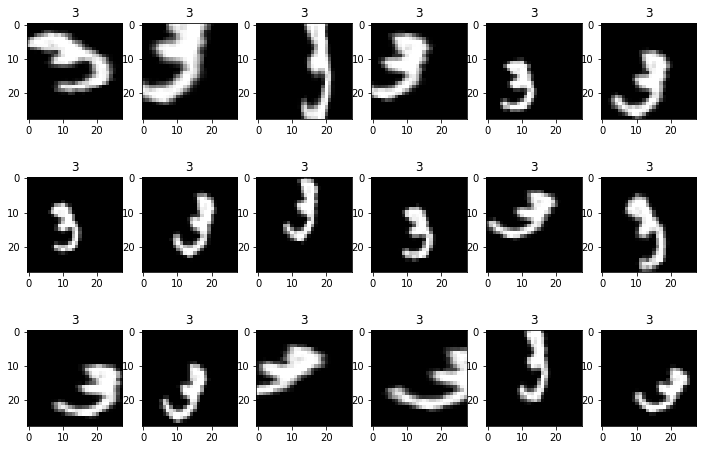

In [ ]:
# construct the image generator for data augmentation then
# initialize the total number of images generated thus far
aug = ImageDataGenerator(rotation_range=40, width_shift_range=0.2,
                         height_shift_range=0.2, shear_range=0.2, zoom_range=0.5,
                         horizontal_flip=False, fill_mode="nearest")
total = 0
image = train_x[10:11,:,:,:]

# construct the actual Python generator
print("[INFO] generating images...")
imageGen = aug.flow(image, batch_size=1)

# create a figure
plt.figure(figsize=(12, 8))

# loop over examples from our image data augmentation generator
for img in imageGen:

  show_image(img, train_y[10], total)

  # increment our counter
  total += 1

  # if we have reached 10 examples, break from the loop
  if total == 18:
    break

Normalize the data

In [ ]:
# scale data to the range of [0, 1]
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

# convert the labels from integers to vectors
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
test_y = lb.transform(test_y)

###**Training**

In [ ]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# initialize the optimizer and model
logger.info("[INFO] compiling model...")
opt = Adam(learning_rate=0.005)
model = PacodaNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

aug = ImageDataGenerator(rotation_range=40, width_shift_range=0.2,
                         height_shift_range=0.2, shear_range=0.2, zoom_range=0.5,
                         horizontal_flip=False, fill_mode="nearest")

# train the network
logger.info("[INFO] training network...")
history = model.fit(aug.flow(train_x, train_y, batch_size=64),
                    validation_data=(test_x, test_y), 
                    epochs=20, 
                    verbose=0,
                    callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                         compute_flops=True)])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

06-11-2022 02:17:22 [INFO] compiling model...
06-11-2022 02:17:22 [INFO] training network...
06-11-2022 02:17:22 From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_ops.py:5219: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


### **Evaluation Metrics**

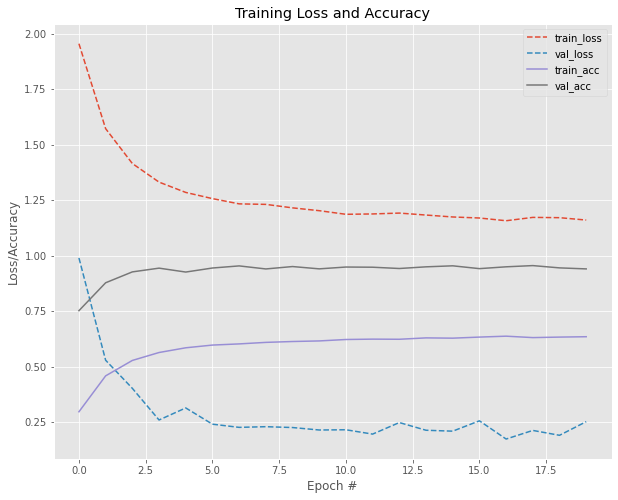

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [ ]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.008747056717239599 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.0005379522233418399 kWh
[INFO] Energy consumed for all GPU: 0.003397083061080774 kWh
[INFO] Energy consumed for all CPU: 0.004812021432816983 kWh
[INFO] CO2 emission 0.003471490022123804(in Kg)


In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=32)
print(classification_report(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[str(i) for i in lb.classes_]))

[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       980
           1       1.00      0.96      0.98      1135
           2       0.92      0.96      0.94      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.84      0.90       982
           5       0.97      0.95      0.96       892
           6       0.87      0.97      0.92       958
           7       0.97      0.88      0.92      1028
           8       0.89      0.95      0.92       974
           9       0.92      0.92      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



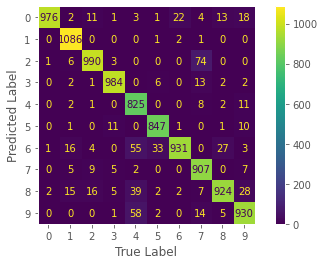

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                        test_y.argmax(axis=1)),
                       display_labels=lb.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

06-11-2022 02:27:07 Uploading figures


In [ ]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(test_y.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(test_y.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(test_y.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

06-11-2022 02:27:10 Validation Evaluation metrics
06-11-2022 02:27:10 Validation Accuracy: 0.94
06-11-2022 02:27:10 Validation Precision: 0.9423053271626246
06-11-2022 02:27:10 Validation Recall: 0.94
06-11-2022 02:27:10 Validation F1: 0.9398930240646992


In [ ]:
run.finish()

## Step 04: Hyperparameter tuning with W&B Sweep

In [ ]:
# Configure the sweep 
sweep_config = {
    'method': 'random', 
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        # Normal model
        'conv_layer': { 'max': 4, 'min': 1, 'distribution': 'int_uniform', },
        'filters': { 'values': [6, 12, 16] },
        'learn_rate': { 'values': [0.001, 0.005] },
        'epochs': { 'values': [10, 20] },
        'batch_size': { 'values': [32,64] },
        'dropout': { 'values' : [0.25, 0.5] },
        'dropout_fc': { 'values' : [0.25, 0.5]},
        'pooling' : { 'values': [0, 1]},

        # Augmentation
        'rotation_range': { 'values' : [20, 30] },
        'width_shift_range': { 'values' : [0.1, 0.2] },
        'height_shift_range': { 'values' : [0.1, 0.2] },
        'shear_range' : { 'values' : [0.2, 0.3] },
        'zoom_range' : { 'values' : [0.3, 0.4] }
    }
}

Initialize a new sweep
Arguments:

* sweep_config: the sweep config dictionary defined above
* entity: Set the username for the sweep
* project: Set the project name for the sweep

In [ ]:
sweep_id = wandb.sweep(sweep_config,
                       entity="euripedes",
                       project=args["project_name"])

Create sweep with ID: qdzs0nra
Sweep URL: https://wandb.ai/euripedes/padoca-net/sweeps/qdzs0nra


**Adapting the model**

In [ ]:
class PacodaNetTuned:
  @staticmethod
  def build(width, height, depth, classes, config):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   
    # first set of CONV => RELU => POOL layers
    for i in range(config.conv_layer):
      model.add(Conv2D(config.filters, (5,5), strides=1, padding='same',
                     activation='relu', input_shape=(28,28,1), ))
      model.add(BatchNormalization())
      if config.pooling == 1:
        model.add(MaxPooling2D())
      else:
        model.add(AveragePooling2D())
      model.add(Dropout(config.dropout)) 

    # a flatten and two set of FC => RELU layers
    model.add(Flatten()) #Flatten
    model.add(Dense(120, activation='relu'))
    model.add(Dropout(config.dropout_fc)) 
    model.add(Dense(84, activation='relu')) 
    model.add(Dropout(config.dropout_fc))

    # softmax classifier
    model.add(Dense(10, activation='softmax')) #Output layer
    
    # return the constructed network architecture
    return model

**Training**

In [ ]:
def train():
  with wandb.init() as run:
    # create codecarbon tracker
    # codecarbon is too much verbose, change the log level for more info
    tracker = EmissionsTracker(log_level="critical")
    tracker.start()

    # initialize the optimizer and model
    logger.info("[INFO] compiling model...")
    opt = Adam(learning_rate=run.config.learn_rate)
    model = PacodaNetTuned.build(width=28, height=28, depth=1, 
                                         classes=10, config=run.config)
    model.compile(loss="categorical_crossentropy", optimizer=opt,
                  metrics=["accuracy"])

    # construct the image generator for data augmentation then
    # initialize the total number of images generated thus far
    aug = ImageDataGenerator(rotation_range = run.config.rotation_range,
                             width_shift_range = run.config.width_shift_range,
                            height_shift_range = run.config.height_shift_range, 
                             shear_range = run.config.shear_range, 
                            zoom_range = run.config.zoom_range,
                            horizontal_flip=False, 
                             fill_mode="nearest")

    # train the network
    logger.info("[INFO] training network...")
    history = model.fit(aug.flow(train_x, train_y, batch_size = run.config.batch_size),
                        validation_data=(test_x, test_y),
                        epochs=run.config.epochs, 
                        verbose=0,
                        callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                            compute_flops=True)])

    # get co2 emissions from tracker
    # "CO2 emission (in Kg)"
    emissions = tracker.stop()

    # evaluate the network
    print("[INFO] evaluating network...")
    predictions = model.predict(test_x, batch_size=32)
    print(classification_report(test_y.argmax(axis=1),
                                predictions.argmax(axis=1),
                                target_names=[str(i) for i in lb.classes_]))

    # Evaluation Metrics
    logger.info("Validation Evaluation metrics")
    fbeta = fbeta_score(test_y.argmax(axis=1), 
                        predictions.argmax(axis=1), 
                        beta=1, zero_division=1,average='weighted')
    precision = precision_score(test_y.argmax(axis=1),
                                predictions.argmax(axis=1),
                                zero_division=1,average='weighted')
    recall = recall_score(test_y.argmax(axis=1),
                          predictions.argmax(axis=1),
                          zero_division=1,average='weighted')
    acc = accuracy_score(test_y.argmax(axis=1),
                        predictions.argmax(axis=1))

    logger.info("Validation Accuracy: {}".format(acc))
    logger.info("Validation Precision: {}".format(precision))
    logger.info("Validation Recall: {}".format(recall))
    logger.info("Validation F1: {}".format(fbeta))

    run.summary["Acc"] = acc
    run.summary["Precision"] = precision
    run.summary["Recall"] = recall
    run.summary["F1"] = fbeta
    # number of parameters
    run.summary["Count_Params"] = model.count_params()
    # energy unit is kWh
    run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
    run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
    run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
    run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
    # kg
    run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

    run.finish()

In [ ]:
wandb.agent(sweep_id = sweep_id, function=train, count=10)

wandb: Agent Starting Run: 364c2b1e with config:
wandb: 	batch_size: 32
wandb: 	conv_layer: 2
wandb: 	dropout: 0.5
wandb: 	dropout_fc: 0.25
wandb: 	epochs: 20
wandb: 	filters: 16
wandb: 	height_shift_range: 0.1
wandb: 	learn_rate: 0.005
wandb: 	pooling: 1
wandb: 	rotation_range: 20
wandb: 	shear_range: 0.2
wandb: 	width_shift_range: 0.2
wandb: 	zoom_range: 0.3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


06-11-2022 03:10:42 [INFO] compiling model...
06-11-2022 03:10:42 [INFO] training network...
06-11-2022 03:10:42 From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_ops.py:5219: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step


06-11-2022 03:18:37 Validation Evaluation metrics
06-11-2022 03:18:37 Validation Accuracy: 0.9835
06-11-2022 03:18:37 Validation Precision: 0.983714563872701
06-11-2022 03:18:37 Validation Recall: 0.9835
06-11-2022 03:18:37 Validation F1: 0.9835124436257189


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.95      1.00      0.97      1032
           3       0.98      1.00      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.96      0.97      1028
           8       0.99      0.97      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



accuracy,▁▆▇▇▇▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▄▅▆▆▇▇▇▁▆█▇▇█▇██▇
val_loss,▇▄▄▄▃▂▃▂▂▂█▃▁▁▂▂▂▁▁▂
Acc,0.9835
CO2_Emissions,0.00393
Count_Params,112174
Energy_CPU,0.00559
Energy_Consumed,0.0099
Energy_GPU,0.00368


wandb: Agent Starting Run: hft3ys3b with config:
wandb: 	batch_size: 32
wandb: 	conv_layer: 3
wandb: 	dropout: 0.25
wandb: 	dropout_fc: 0.5
wandb: 	epochs: 10
wandb: 	filters: 6
wandb: 	height_shift_range: 0.1
wandb: 	learn_rate: 0.001
wandb: 	pooling: 1
wandb: 	rotation_range: 20
wandb: 	shear_range: 0.3
wandb: 	width_shift_range: 0.1
wandb: 	zoom_range: 0.4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


06-11-2022 03:18:50 [INFO] compiling model...
06-11-2022 03:18:50 [INFO] training network...


[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step


06-11-2022 03:22:55 Validation Evaluation metrics
06-11-2022 03:22:55 Validation Accuracy: 0.9715
06-11-2022 03:22:55 Validation Precision: 0.9716613958264195
06-11-2022 03:22:55 Validation Recall: 0.9715


              precision    recall  f1-score   support

           0       0.98      0.97      0.98       980
           1       0.99      0.98      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.97      0.98      0.97      1010
           4       0.97      0.98      0.97       982
           5       0.98      0.97      0.97       892
           6       0.96      0.98      0.97       958
           7       0.96      0.98      0.97      1028
           8       0.98      0.94      0.96       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



06-11-2022 03:22:55 Validation F1: 0.9714873428301438


accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇▇▇█
val_loss,█▄▂▂▁▂▂▂▁▁
Acc,0.9715
CO2_Emissions,0.00201
Count_Params,19654
Energy_CPU,0.00288
Energy_Consumed,0.00507
Energy_GPU,0.00187


wandb: Agent Starting Run: 28gogepj with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 1
wandb: 	dropout: 0.25
wandb: 	dropout_fc: 0.25
wandb: 	epochs: 20
wandb: 	filters: 12
wandb: 	height_shift_range: 0.2
wandb: 	learn_rate: 0.001
wandb: 	pooling: 0
wandb: 	rotation_range: 30
wandb: 	shear_range: 0.3
wandb: 	width_shift_range: 0.1
wandb: 	zoom_range: 0.3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


06-11-2022 03:23:11 [INFO] compiling model...
06-11-2022 03:23:11 [INFO] training network...


[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step


06-11-2022 03:29:23 Validation Evaluation metrics
06-11-2022 03:29:23 Validation Accuracy: 0.9797
06-11-2022 03:29:23 Validation Precision: 0.9799734266908287
06-11-2022 03:29:23 Validation Recall: 0.9797
06-11-2022 03:29:23 Validation F1: 0.9796957702392652


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.96      0.98      1135
           2       0.96      0.99      0.97      1032
           3       0.97      1.00      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.98      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.96      0.97      1028
           8       0.96      0.99      0.98       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



accuracy,▁▆▆▇▇▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▅▁▇▃▇▅▅▇▆▇█▄▆▇█▇██▇▇
val_loss,▅█▂▆▂▄▄▂▃▂▁▆▃▁▁▁▁▁▂▂
Acc,0.9797
CO2_Emissions,0.00307
Count_Params,293734
Energy_CPU,0.00438
Energy_Consumed,0.00774
Energy_GPU,0.00287


wandb: Agent Starting Run: k508hypq with config:
wandb: 	batch_size: 32
wandb: 	conv_layer: 3
wandb: 	dropout: 0.25
wandb: 	dropout_fc: 0.25
wandb: 	epochs: 20
wandb: 	filters: 4
wandb: 	height_shift_range: 0.1
wandb: 	learn_rate: 0.005
wandb: 	pooling: 1
wandb: 	rotation_range: 30
wandb: 	shear_range: 0.3
wandb: 	width_shift_range: 0.2
wandb: 	zoom_range: 0.4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


06-11-2022 03:29:38 [INFO] compiling model...
06-11-2022 03:29:38 [INFO] training network...


[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step


06-11-2022 03:37:25 Validation Evaluation metrics
06-11-2022 03:37:25 Validation Accuracy: 0.9119
06-11-2022 03:37:25 Validation Precision: 0.9203271938501099
06-11-2022 03:37:25 Validation Recall: 0.9119
06-11-2022 03:37:25 Validation F1: 0.9129146483741993


              precision    recall  f1-score   support

           0       0.94      0.97      0.95       980
           1       1.00      0.89      0.94      1135
           2       0.92      0.92      0.92      1032
           3       0.82      0.99      0.90      1010
           4       0.99      0.84      0.91       982
           5       0.99      0.88      0.93       892
           6       0.96      0.89      0.93       958
           7       0.94      0.88      0.91      1028
           8       0.79      0.95      0.86       974
           9       0.85      0.92      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



accuracy,▁▅▆▇▇▇▇▇████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▇▅▇▇█▇█▅▆▆▆▆▇▅▇▅▆
val_loss,█▄▄▂▃▁▁▁▁▁▃▂▃▃▂▂▄▂▃▃
Acc,0.9119
CO2_Emissions,0.00383
Count_Params,16414
Energy_CPU,0.00549
Energy_Consumed,0.00966
Energy_GPU,0.00355


wandb: Agent Starting Run: jn41yqzb with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 2
wandb: 	dropout: 0.25
wandb: 	dropout_fc: 0.5
wandb: 	epochs: 10
wandb: 	filters: 16
wandb: 	height_shift_range: 0.1
wandb: 	learn_rate: 0.001
wandb: 	pooling: 0
wandb: 	rotation_range: 30
wandb: 	shear_range: 0.3
wandb: 	width_shift_range: 0.2
wandb: 	zoom_range: 0.3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


06-11-2022 03:37:38 [INFO] compiling model...
06-11-2022 03:37:38 [INFO] training network...


[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step


06-11-2022 03:40:45 Validation Evaluation metrics
06-11-2022 03:40:45 Validation Accuracy: 0.9834
06-11-2022 03:40:45 Validation Precision: 0.9835105381341905
06-11-2022 03:40:45 Validation Recall: 0.9834


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      1.00      0.99      1010
           4       0.97      0.99      0.98       982
           5       0.96      0.99      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.98      0.98       974
           9       0.99      0.95      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



06-11-2022 03:40:45 Validation F1: 0.9833715833676637


accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▇▇██▇██
val_loss,█▄▃▂▂▁▁▂▁▁
Acc,0.9834
CO2_Emissions,0.00155
Count_Params,112174
Energy_CPU,0.0022
Energy_Consumed,0.00391
Energy_GPU,0.00147


wandb: Agent Starting Run: z7sx4t2v with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 3
wandb: 	dropout: 0.5
wandb: 	dropout_fc: 0.25
wandb: 	epochs: 10
wandb: 	filters: 16
wandb: 	height_shift_range: 0.1
wandb: 	learn_rate: 0.001
wandb: 	pooling: 0
wandb: 	rotation_range: 30
wandb: 	shear_range: 0.2
wandb: 	width_shift_range: 0.2
wandb: 	zoom_range: 0.3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


06-11-2022 03:40:57 [INFO] compiling model...
06-11-2022 03:40:57 [INFO] training network...


[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step


06-11-2022 03:44:07 Validation Evaluation metrics
06-11-2022 03:44:07 Validation Accuracy: 0.9712
06-11-2022 03:44:07 Validation Precision: 0.9720188861604719
06-11-2022 03:44:07 Validation Recall: 0.9712
06-11-2022 03:44:07 Validation F1: 0.9712458156345898


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       980
           1       1.00      0.96      0.98      1135
           2       0.96      0.98      0.97      1032
           3       0.96      1.00      0.98      1010
           4       0.98      0.95      0.96       982
           5       1.00      0.95      0.97       892
           6       0.98      0.99      0.98       958
           7       0.98      0.94      0.96      1028
           8       0.92      0.99      0.96       974
           9       0.94      0.97      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



accuracy,▁▆▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▄▅▇████▇▇
val_loss,█▅▃▂▁▁▁▁▁▂
Acc,0.9712
CO2_Emissions,0.00159
Count_Params,41854
Energy_CPU,0.00224
Energy_Consumed,0.00402
Energy_GPU,0.00153


wandb: Agent Starting Run: 6tlymx50 with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 3
wandb: 	dropout: 0.25
wandb: 	dropout_fc: 0.5
wandb: 	epochs: 20
wandb: 	filters: 6
wandb: 	height_shift_range: 0.1
wandb: 	learn_rate: 0.001
wandb: 	pooling: 1
wandb: 	rotation_range: 30
wandb: 	shear_range: 0.2
wandb: 	width_shift_range: 0.2
wandb: 	zoom_range: 0.3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


06-11-2022 03:44:20 [INFO] compiling model...
06-11-2022 03:44:20 [INFO] training network...


[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step


06-11-2022 03:50:39 Validation Evaluation metrics
06-11-2022 03:50:39 Validation Accuracy: 0.9615
06-11-2022 03:50:39 Validation Precision: 0.9626948539316196
06-11-2022 03:50:39 Validation Recall: 0.9615
06-11-2022 03:50:39 Validation F1: 0.9615853482423128


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       1.00      0.96      0.98      1135
           2       0.92      0.97      0.95      1032
           3       0.96      0.98      0.97      1010
           4       0.99      0.91      0.95       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.92      0.95      1028
           8       0.92      0.98      0.95       974
           9       0.92      0.96      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



accuracy,▁▄▆▇▇▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇█████████████████
val_loss,█▃▃▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc,0.9615
CO2_Emissions,0.00312
Count_Params,19654
Energy_CPU,0.00445
Energy_Consumed,0.00785
Energy_GPU,0.00291


wandb: Agent Starting Run: 7atsuw4u with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 1
wandb: 	dropout: 0.5
wandb: 	dropout_fc: 0.5
wandb: 	epochs: 20
wandb: 	filters: 16
wandb: 	height_shift_range: 0.1
wandb: 	learn_rate: 0.001
wandb: 	pooling: 1
wandb: 	rotation_range: 30
wandb: 	shear_range: 0.3
wandb: 	width_shift_range: 0.2
wandb: 	zoom_range: 0.3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


06-11-2022 03:50:54 [INFO] compiling model...
06-11-2022 03:50:54 [INFO] training network...


[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step


06-11-2022 03:57:06 Validation Evaluation metrics


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       980
           1       1.00      0.89      0.94      1135
           2       0.94      0.99      0.96      1032
           3       0.93      1.00      0.96      1010
           4       0.95      0.96      0.96       982
           5       0.98      0.97      0.97       892
           6       0.98      0.96      0.97       958
           7       0.99      0.93      0.96      1028
           8       0.84      0.99      0.91       974
           9       0.97      0.91      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.95      0.96     10000



06-11-2022 03:57:06 Validation Accuracy: 0.9549
06-11-2022 03:57:06 Validation Precision: 0.9581380709546998
06-11-2022 03:57:06 Validation Recall: 0.9549
06-11-2022 03:57:06 Validation F1: 0.9551590276328931


accuracy,▁▅▆▇▇▇▇▇████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▇▇█▇▇▇█▇█████▇██▇
val_loss,█▅▄▂▂▁▂▂▂▁▂▁▁▁▁▁▂▁▁▂
Acc,0.9549
CO2_Emissions,0.00308
Count_Params,387934
Energy_CPU,0.00438
Energy_Consumed,0.00776
Energy_GPU,0.00289


wandb: Agent Starting Run: xwojdocl with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 2
wandb: 	dropout: 0.5
wandb: 	dropout_fc: 0.5
wandb: 	epochs: 10
wandb: 	filters: 12
wandb: 	height_shift_range: 0.1
wandb: 	learn_rate: 0.001
wandb: 	pooling: 0
wandb: 	rotation_range: 20
wandb: 	shear_range: 0.3
wandb: 	width_shift_range: 0.1
wandb: 	zoom_range: 0.3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


06-11-2022 03:57:21 [INFO] compiling model...
06-11-2022 03:57:21 [INFO] training network...


[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step


06-11-2022 04:00:27 Validation Evaluation metrics
06-11-2022 04:00:27 Validation Accuracy: 0.9825
06-11-2022 04:00:27 Validation Precision: 0.9826431967412788
06-11-2022 04:00:27 Validation Recall: 0.9825
06-11-2022 04:00:27 Validation F1: 0.9824845657582255


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.98      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.98      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.96      0.99      0.98      1028
           8       0.99      0.97      0.98       974
           9       0.98      0.95      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇▇██
val_loss,█▄▂▂▂▂▁▁▁▁
Acc,0.9825
CO2_Emissions,0.00154
Count_Params,85714
Energy_CPU,0.00218
Energy_Consumed,0.00387
Energy_GPU,0.00145


wandb: Agent Starting Run: 5o8rvlh8 with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 2
wandb: 	dropout: 0.25
wandb: 	dropout_fc: 0.25
wandb: 	epochs: 10
wandb: 	filters: 12
wandb: 	height_shift_range: 0.1
wandb: 	learn_rate: 0.005
wandb: 	pooling: 1
wandb: 	rotation_range: 30
wandb: 	shear_range: 0.2
wandb: 	width_shift_range: 0.1
wandb: 	zoom_range: 0.4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


06-11-2022 04:00:40 [INFO] compiling model...
06-11-2022 04:00:40 [INFO] training network...


[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step


06-11-2022 04:03:49 Validation Evaluation metrics


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      0.99      0.99      1135
           2       0.98      1.00      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.98      0.99       892
           6       0.98      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.99      0.98      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



06-11-2022 04:03:49 Validation Accuracy: 0.9858
06-11-2022 04:03:49 Validation Precision: 0.985839145071142
06-11-2022 04:03:49 Validation Recall: 0.9858
06-11-2022 04:03:49 Validation F1: 0.9857939849766088


accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▃▁▇▇▃▆██▇█
val_loss,▆█▂▂▆▄▁▁▁▁
Acc,0.9858
CO2_Emissions,0.00157
Count_Params,85714
Energy_CPU,0.00223
Energy_Consumed,0.00396
Energy_GPU,0.00149


## Step 05: Train and Export the best model to W&B

With the results of Sweeps we know which configuration is the best and now we need to save it in our W&B project.

* It's important to understand that since we used the "random" method from WandB this model its not necessarily the best possible, it means that it was the best from all the combinations formed during the hyperparameter tuning process.  

Speak of it, that's the best configuration that Sweeps showed us:


* batch_size: 64
*	conv_layer: 2
* dropout: 0.25
* dropout_fc: 0.25
* epochs: 10
* filters: 12
*	height_shift_range: 0.1
*	learn_rate: 0.005
*	pooling: 1
*	rotation_range: 30
*	shear_range: 0.2
*	width_shift_range: 0.1
*	zoom_range: 0.4

### Creating the Best Model

In [ ]:
args = {
  "project_name": "padoca-net",
  "encoder": "target_encoder"
}

In [ ]:
run = wandb.init(entity="euripedes",
                 project=args["project_name"], 
                 job_type="Final_model")

wandb: Currently logged in as: euripedes. Use `wandb login --relogin` to force relogin


### Fetch, Preprocessing and Data Segregation

***Run the same process we did before!***

### Training

In [ ]:
class UpdatedPacodaNet:
  @staticmethod
  def build(width, height, depth, classes):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   
    # first set of CONV => RELU => POOL layers
    for i in range(2):
      model.add(Conv2D(12, (5,5), strides=1, padding='same',
                     activation='relu', input_shape=(28,28,1), ))
      model.add(BatchNormalization())
      model.add(MaxPooling2D())
      model.add(Dropout(0.25)) 

    # a flatten and two set of FC => RELU layers
    model.add(Flatten()) #Flatten
    model.add(Dense(120, activation='relu'))
    model.add(Dropout(0.25)) 
    model.add(Dense(84, activation='relu')) 
    model.add(Dropout(0.25))

    # softmax classifier
    model.add(Dense(10, activation='softmax')) #Output layer
    
    # return the constructed network architecture
    return model

In [ ]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# initialize the optimizer and model
logger.info("[INFO] compiling model...")
opt = Adam(learning_rate=0.005)
model = UpdatedPacodaNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.4,
                         horizontal_flip=False, fill_mode="nearest")

# train the network
logger.info("[INFO] training network...")
history = model.fit(aug.flow(train_x, train_y, batch_size=64),
                    validation_data=(test_x, test_y), 
                    epochs=10, 
                    verbose=0,
                    callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                         compute_flops=True)])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

06-11-2022 04:21:02 [INFO] compiling model...
06-11-2022 04:21:04 [INFO] training network...
06-11-2022 04:21:05 From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_ops.py:5219: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


### Evaluation Metrics

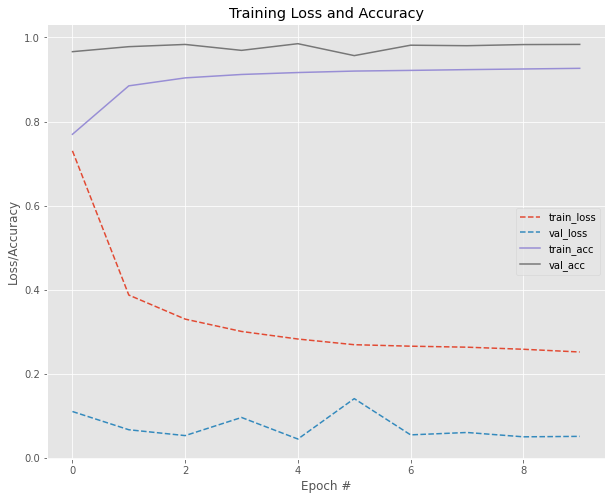

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 10), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 10), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [ ]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.0050898996639660845 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.00031348513751246817 kWh
[INFO] Energy consumed for all GPU: 0.001972681202276879 kWh
[INFO] Energy consumed for all CPU: 0.0028037333241767355 kWh
[INFO] CO2 emission 0.0032116409915061445(in Kg)


In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=32)
print(classification_report(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[str(i) for i in lb.classes_]))

[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       0.99      0.98      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.98      1.00      0.99      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.97      0.99      0.98       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.98      0.98       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



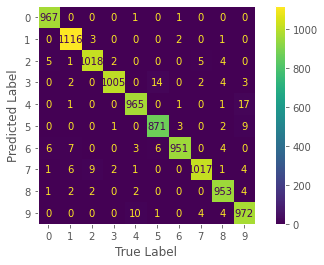

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                        test_y.argmax(axis=1)),
                       display_labels=lb.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

06-11-2022 04:26:04 Uploading figures


In [ ]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(test_y.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(test_y.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(test_y.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

06-11-2022 04:26:07 Validation Evaluation metrics
06-11-2022 04:26:07 Validation Accuracy: 0.9835
06-11-2022 04:26:07 Validation Precision: 0.9835747950746876
06-11-2022 04:26:07 Validation Recall: 0.9835
06-11-2022 04:26:07 Validation F1: 0.9834960113382216


Now we can finish our process! ✅

In [ ]:
run.finish()

accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▃▆█▄█▁▇▇▇█
val_loss,▆▃▂▅▁█▂▂▁▁
Acc,0.9835
CO2_Emissions,0.00321
Count_Params,85714
Energy_CPU,0.0028
Energy_Consumed,0.00509
Energy_GPU,0.00197
